# Storing each 50ms row as a seperate spectrum
50 ms row = 1102 samples

13 rows = 650ms

In [118]:
import scipy
import scipy.signal
import numpy as np
import librosa
import librosa.display
from scipy.io import wavfile
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 4.0)
import matplotlib.pyplot as plt

In [2]:
def restore(D, frame_size, hop_length, epochs=100, length=None):

    D = np.concatenate((np.zeros((D.shape[0], 1)), D, np.zeros((D.shape[0], 1))), axis=1)
    mag, _ = librosa.magphase(D)
    
    phase = np.exp(1.j * np.random.uniform(0., 2*np.pi, size=mag.shape))
    x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, length=length)
    
    for i in range(epochs):
        _, phase = librosa.magphase(librosa.stft(x_, n_fft=frame_size, hop_length=hop_length, center=False))
        x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, length=length)
        
    return x_[hop_length:-hop_length]

### Loading Sounds

In [3]:
names = {'Ba.wav', 'fa.wav', 'Ga.wav', 'Ma.wav', 'Ra.wav', 'Bu.wav', 'Ru.wav', 'mu.wav', 'fu.wav', 'Gu.wav'}
path = '/home/srg/Documents/MSU/EEG/data/sound_files/'
SR = 22050

Sounds = []
for name in names:
    Sounds.append(librosa.load(path + name, sr=SR)[0])

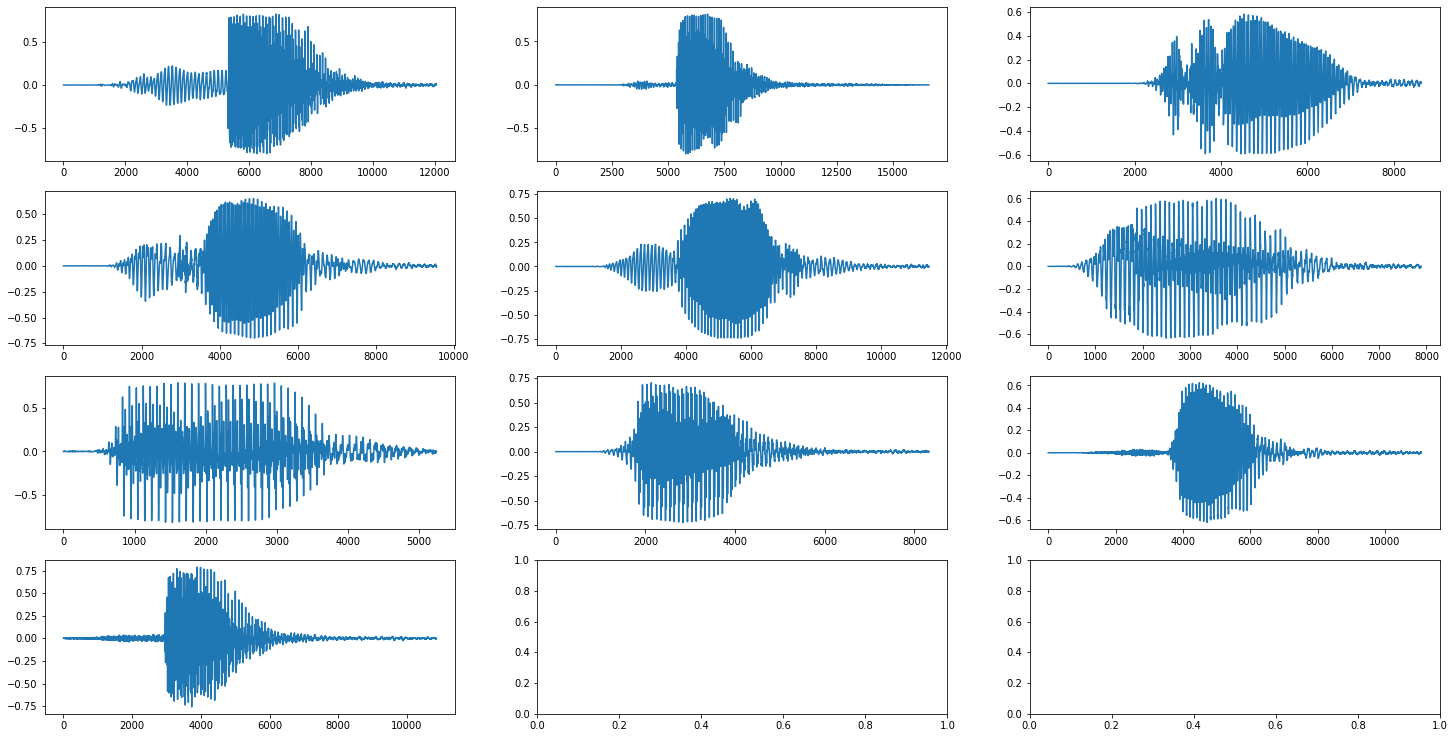

In [13]:
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(Sounds[3 * i + j])
        if 3 * i + j == 9:
            break

### Reshaping to 650 ms

In [5]:
Snd = np.empty((0, 14326))
for sig in Sounds:
    if sig.shape[0] <= 14326:
        mod = sig.shape[0] % 2
        tmp = np.pad(sig, ((14326 - sig.shape[0]) // 2 + mod,
                           (14326 - sig.shape[0]) // 2), 'constant', constant_values=(0, 0))
        Snd = np.append(Snd, tmp.reshape(1, -1), axis=0)
    else:
        Snd = np.append(Snd, sig[:14326].reshape(1, -1), axis=0)
Snd = Snd.reshape(10, 13, 1102)
Snd.shape

(10, 13, 1102)

### Computing spetrums

In [13]:
FRAME_SIZE = 1102
SR = 22050
HOP_LENGTH = 1102 * 2

In [73]:
Specs = np.empty((0, 552))
for syl in Snd:
    for row in syl:
        x = np.abs(librosa.stft(row, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False))
        Specs = np.append(Specs, x.T, axis=0) # x is (552, 1)
Specs = Specs.reshape(10, 13, 552)
Specs.shape

(10, 13, 552)

### Back to sound

In [74]:
Signal = np.empty((0, 1102))
for spec in Specs.reshape(130, 552):
    x_ = restore(spec.reshape(552, 1), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)

#### Plotting restored sounds

In [95]:
cutSignal = Signal.reshape(10, -1)
cutSignal = cutSignal * (cutSignal < 1) * (cutSignal > -1)

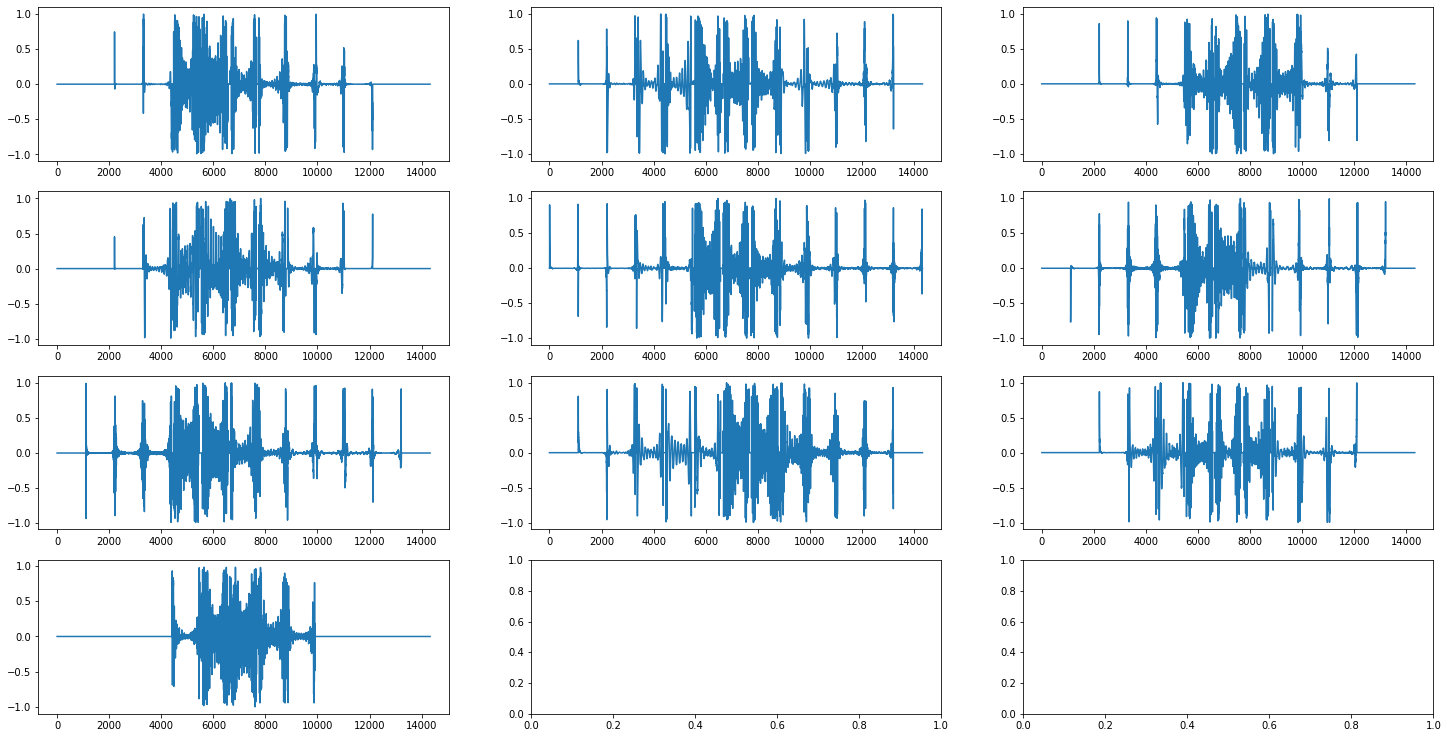

In [31]:
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(cutSignal[3 * i + j])
        if 3 * i + j == 9:
            break

### Analysis

#### Plotting windows for 1st syllable

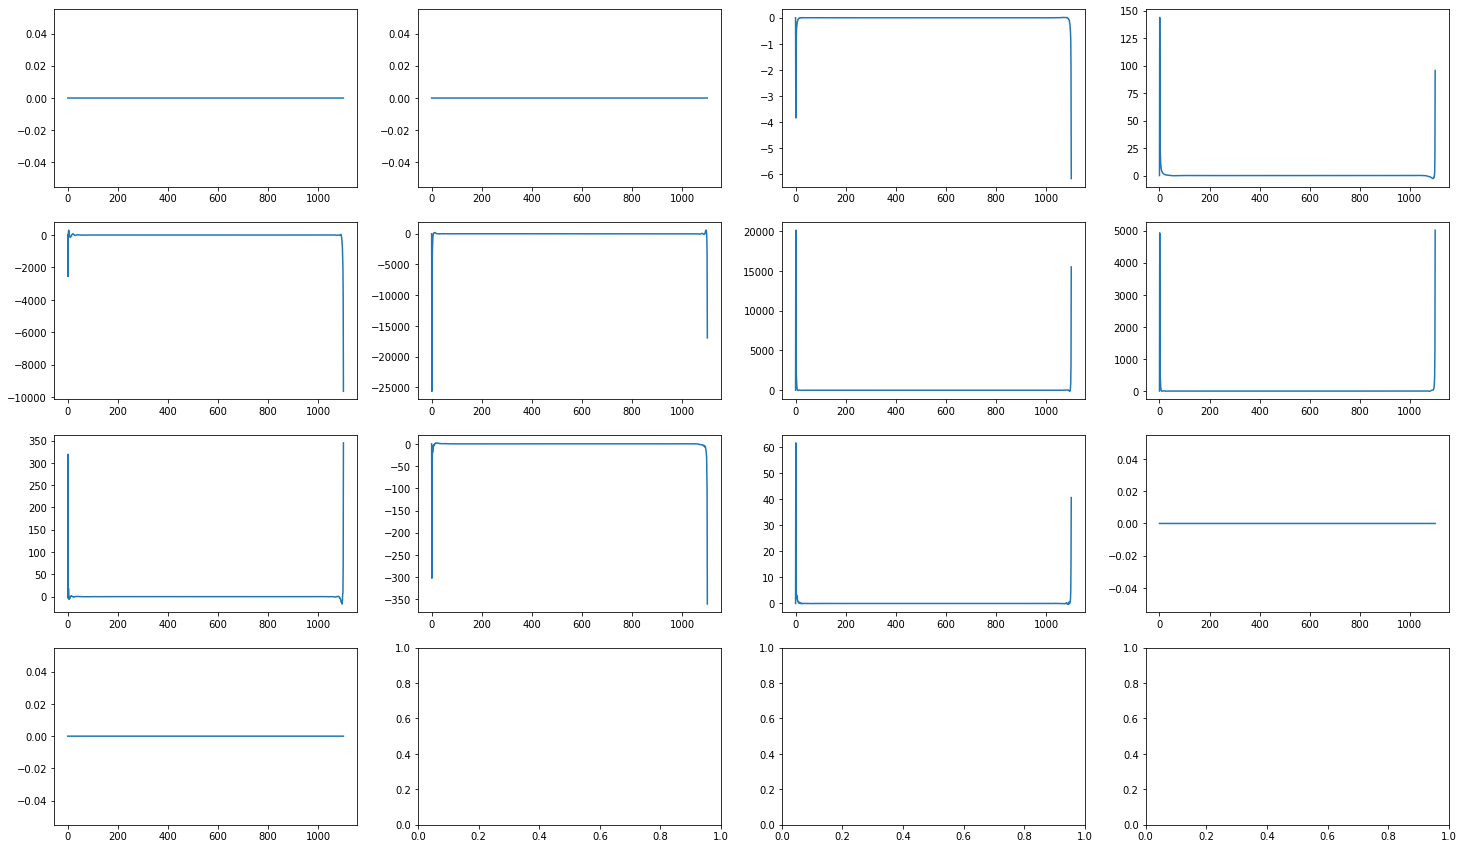

In [75]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j])
        if 4 * i + j == 12:
            break

#### Shutting off first and last 20 samples

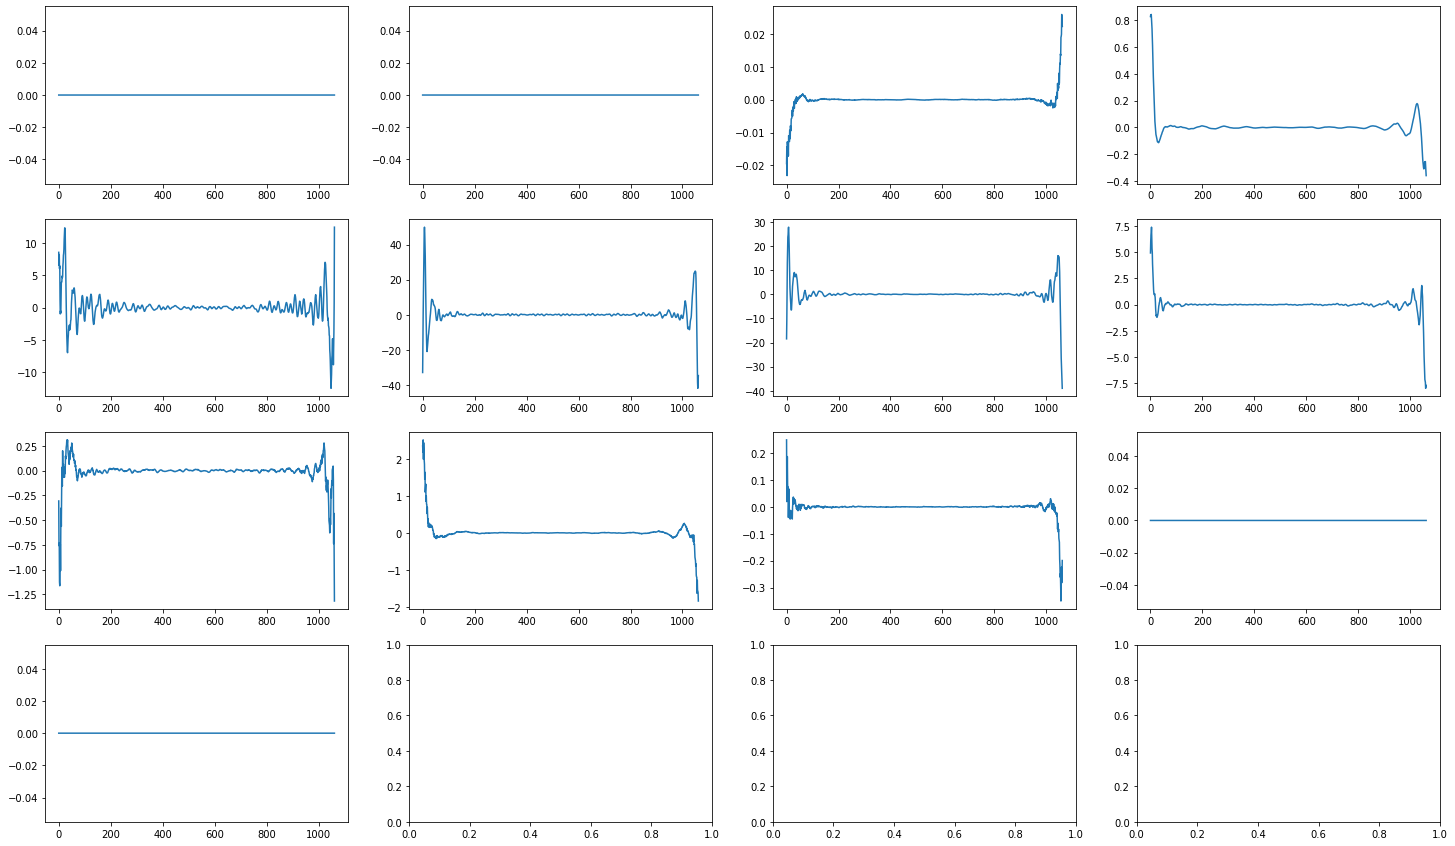

In [37]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j][20:-20])
        if 4 * i + j == 12:
            break

In [40]:
# Saving...

save = np.empty(0)
for i in range(4):
    for j in range(4):
        save = np.append(save, Signal[4 * i + j][20:-20], axis=0)
        if 4 * i + j == 12:
            break

scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, save)
# Result: bad quality as expected

In [96]:
x = cutSignal[0][(cutSignal[0] > 0.05) | (cutSignal[0] < -0.05)]
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, x)
x.shape

(3039,)

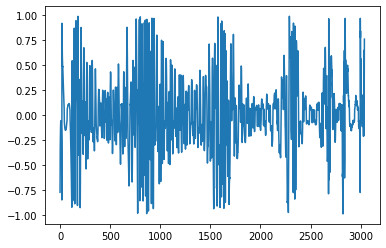

In [97]:
plt.plot(x)

# 50 ms row -> 10 frames

In [6]:
FRAME_SIZE = 346
SR = 22050
HOP_LENGTH = 84

In [127]:
Snd.shape

(10, 13, 1102)

In [146]:
Specs = np.empty((0, 1740))
for syl in Snd:
    for row in syl:
        x = np.abs(librosa.stft(row, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False)).reshape(1, -1)
        Specs = np.append(Specs, x, axis=0)
Specs = Specs.reshape(10, 13, 1740)
Specs.shape

(10, 13, 1740)

In [147]:
Specs = np.concatenate((Specs[-1].reshape(1, 13, 1740), Specs[:-1]), axis=0)

In [107]:
Signal = np.empty((0, 1102))
for spec in Specs.reshape(130, 1740):
    x_ = restore(spec.reshape(174, 10), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)
x = np.squeeze(Signal.reshape(-1, 1))
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, x)

### 10 syllable plots

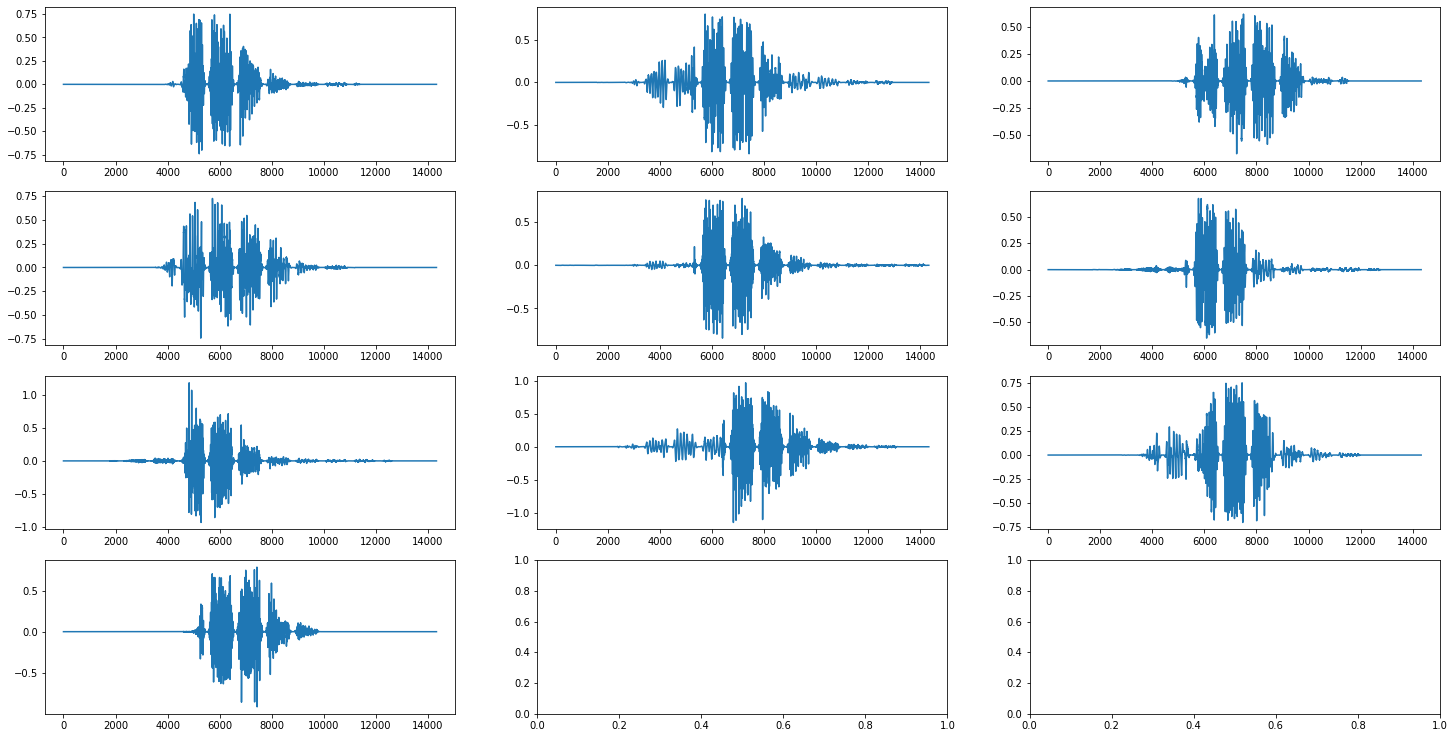

In [108]:
pltSignal = Signal.reshape(10, -1)
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(pltSignal[3 * i + j])
        if 3 * i + j == 9:
            break

### 1st syllable (all 13 rows)

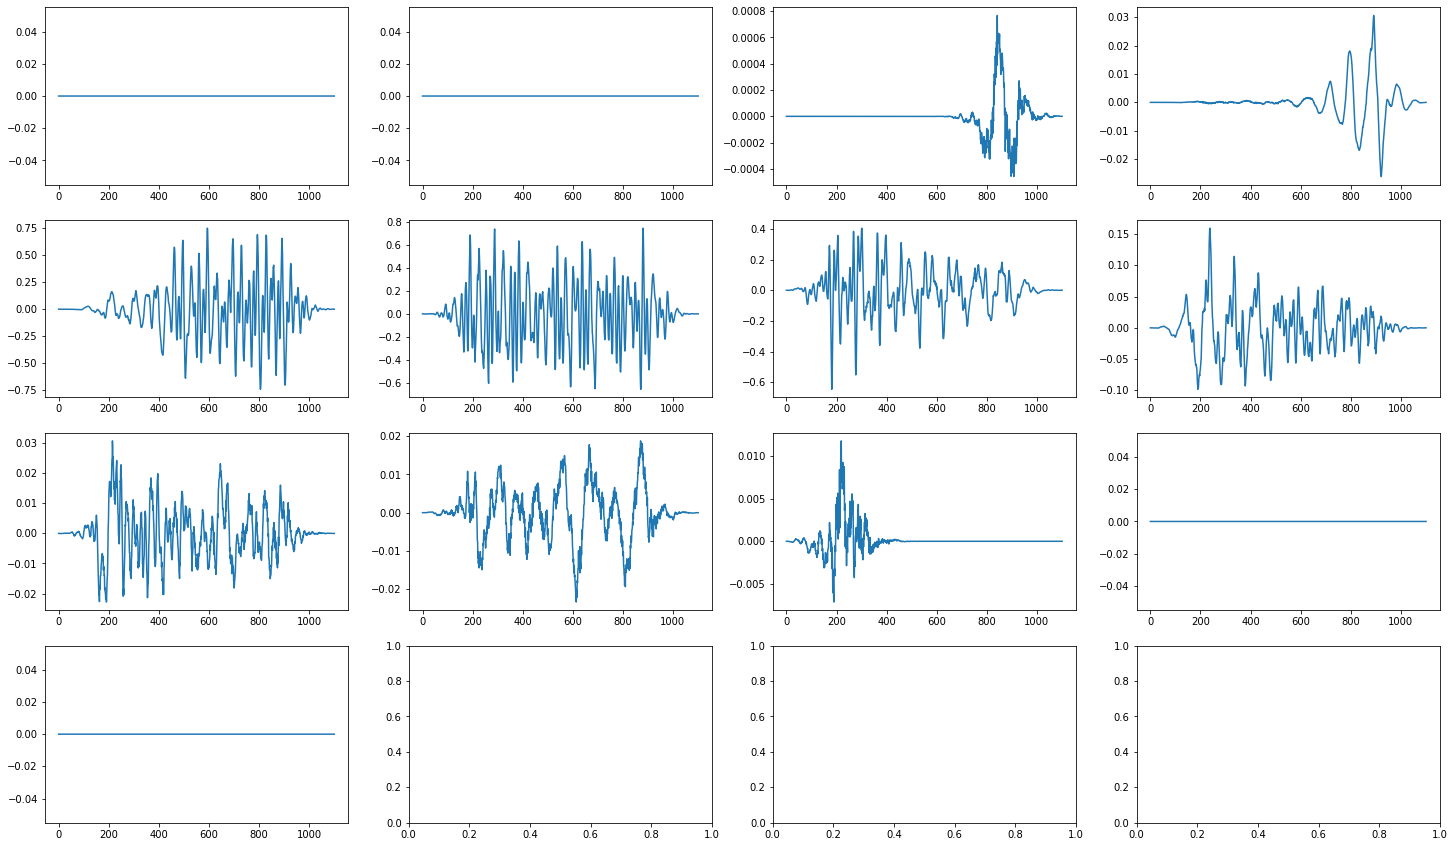

In [119]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j])
        if 4 * i + j == 12:
            break

In [136]:
### Saving filtered file

save = np.empty(0)
for i in range(130):
    save = np.append(save, Signal[i][110:-110], axis=0)
    
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/cut.wav', SR, save)

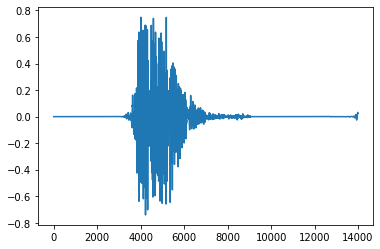

In [137]:
plt.plot(save[:14000])

### A, B matrices

In [103]:
A = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/VIE_bashirinslsl_och.csv', delimiter=';', ndmin=2)
label = A[:, 0]
A = A[:, 1:]
A.shape

(16187, 36)

In [130]:
# 13 in between

def get_nearest(label, ind):
    while label[ind] != 0:
        ind += 1
    return ind - 1

restricted_mode = False 
rest_num = 1
rest_arr = np.zeros(10)
indices1 = np.empty(0)
indices2 = np.empty(0)
hops = 12 # zeroes
flag = 0 # in block 
count = 0

for i, val in enumerate(label):
    if val == 0:
        if flag:
            count += 1
            continue
        else:
            continue
    
    if val > 10:
        if restricted_mode & (rest_arr[int(val) % 10] == rest_num):
            continue
        count = 0
        flag = 1
        last_ind = i
    else:
        if count != hops:
            count = 0
            continue
        else: 
            count = 0
            flag = 0
            rest_arr[int(val) % 10] += 1
            indices1 = np.append(indices1, last_ind)
            indices2 = np.append(indices2, get_nearest(label, i))
            
indices1 = np.array(sorted(list(set(indices1).union(*[set(indices1 + j) for j in range(1, 13)]))))
indices2 = np.array(sorted(list(set(indices2).union(*[set(indices2 + j) for j in range(1, 13)]))))
inds = np.array(sorted(list(set(indices1).union(indices2)))).astype(int)
label[inds][::13]

array([18.,  8., 13.,  3., 13.,  3., 14.,  4., 19.,  9., 20., 10., 19.,
        9., 16.,  6., 18.,  8., 18.,  8., 19.,  9., 17.,  7., 15.,  5.,
       11.,  1., 13.,  3., 11.,  1., 11.,  1., 15.,  5., 14.,  4., 17.,
        7., 17.,  7., 15.,  5., 17.,  7., 19.,  9., 18.,  8., 12.,  2.,
       20., 10., 16.,  6., 20., 10., 12.,  2., 16.,  6., 18.,  8., 14.,
        4., 20., 10., 15.,  5., 16.,  6., 12.,  2., 18.,  8., 11.,  1.,
       11.,  1., 15.,  5., 16.,  6., 15.,  5., 11.,  1., 17.,  7., 11.,
        1., 19.,  9., 20., 10., 15.,  5., 11.,  1., 13.,  3., 20., 10.,
       20., 10., 20., 10., 18.,  8., 17.,  7., 12.,  2., 19.,  9., 16.,
        6., 15.,  5., 20., 10., 17.,  7., 11.,  1., 15.,  5., 14.,  4.,
       14.,  4., 20., 10., 20., 10., 11.,  1., 18.,  8., 16.,  6., 20.,
       10., 19.,  9., 14.,  4., 11.,  1., 17.,  7., 15.,  5., 11.,  1.,
       14.,  4., 18.,  8., 20., 10., 12.,  2., 16.,  6., 14.,  4., 12.,
        2., 13.,  3., 15.,  5., 15.,  5., 18.,  8., 13.,  3., 12

In [131]:
tmp = inds[label[inds] == 11]
tmp = np.array(sorted(list(set(tmp).union(*[set(tmp + j) for j in range(1, 13)]))))
label[tmp]

array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [195]:
inds = tmp[:130].astype(int)

In [196]:
B = np.empty((0, 1740))

for l in label[inds][::13]:
    B = np.append(B, Specs[int(l) % 10], axis=0)
B.shape

(130, 1740)

In [197]:
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/A.csv", A[inds], delimiter=",")
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/Ainv.csv", np.linalg.pinv(A[inds]), delimiter=",")
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/B.csv", B, delimiter=",")

# Training X

In [198]:
Aplus = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/Ainv.csv', delimiter=',', ndmin=2)
B = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/B.csv', delimiter=',', ndmin=2)
X = np.dot(Aplus, B)
X.shape

(36, 1740)

In [199]:
Atest = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/A.csv', delimiter=',', ndmin=2)
Res = np.dot(Atest, X)

In [200]:
Signal = np.empty((0, 1102))
for spec in Res:
    x_ = restore(spec.reshape(174, 10), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)
x = np.squeeze(Signal.reshape(-1, 1))
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/130rows.wav', SR, x)

### csv data research

In [105]:
inds.shape

(3484,)

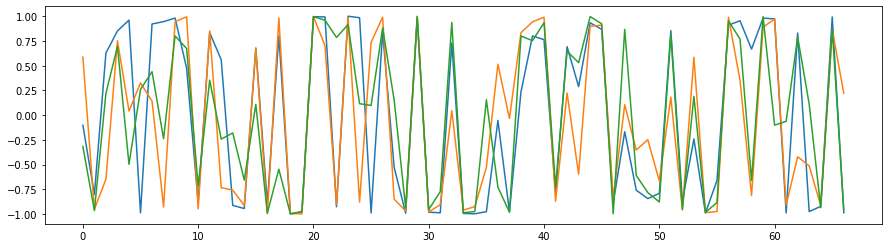

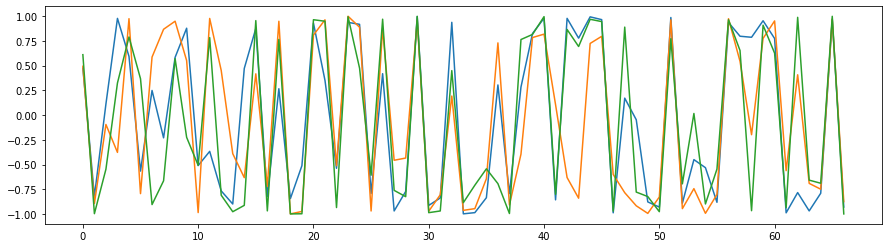

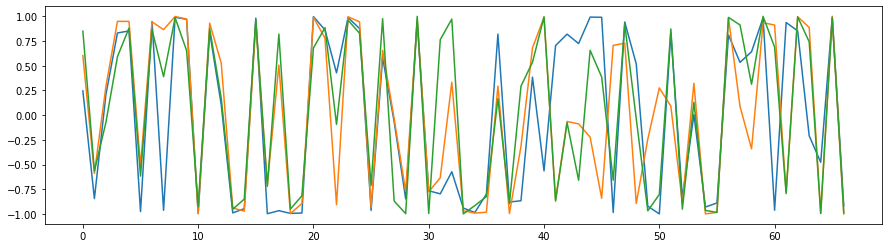

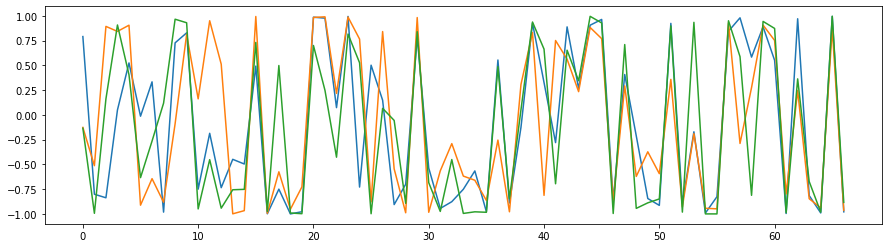

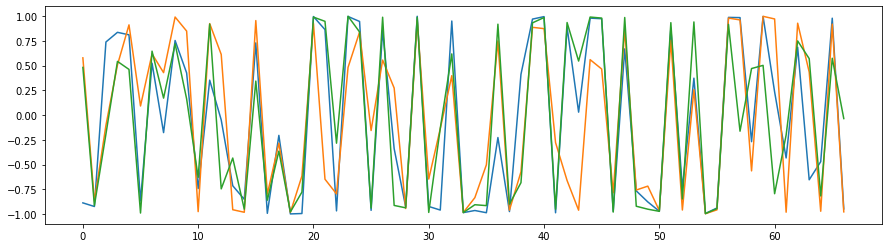

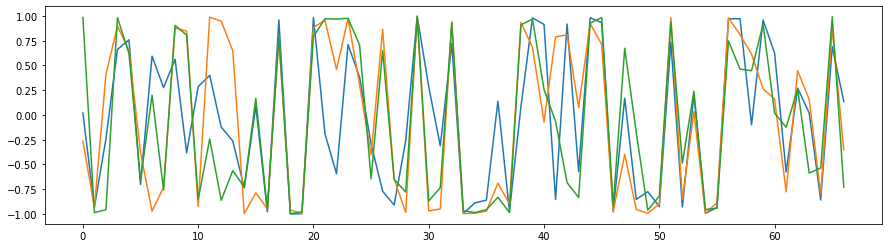

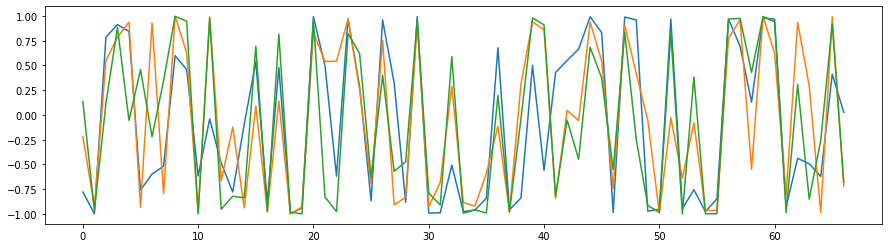

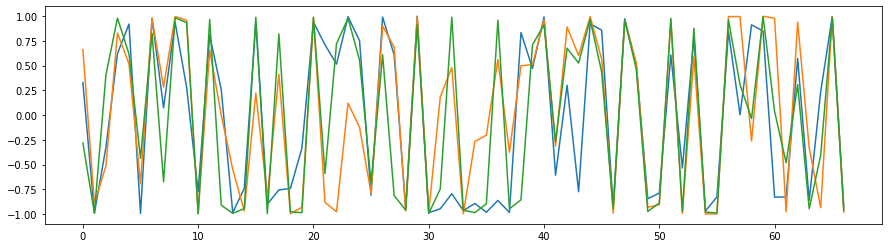

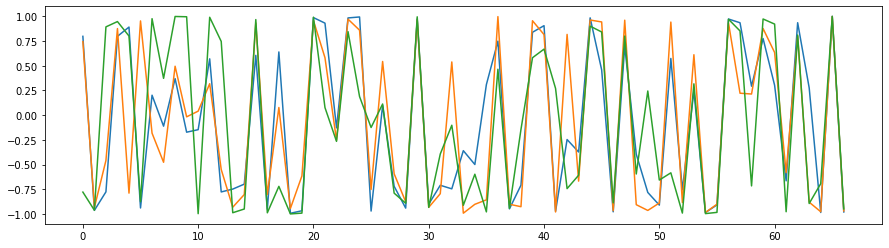

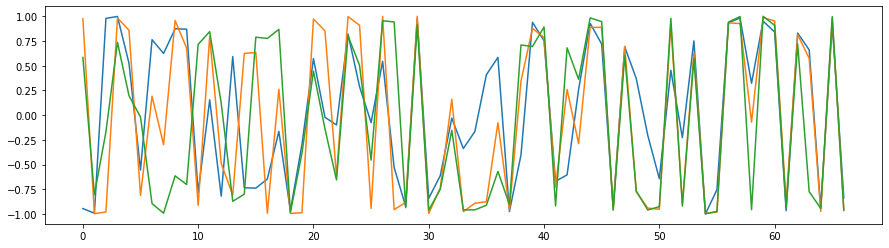

In [122]:
#fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        tmp = inds[label[inds] == 11 + 3 * i + j]
        tmp = np.array(sorted(list(set(tmp).union(*[set(tmp + j) for j in range(1, 13)]))))
        for graph in A[tmp].reshape(-1, 468)[:3, ::7]:
            #axes[i][j].plot(graph)
            plt.plot(graph)
        plt.show()
        if 3 * i + j == 9:
            break
